## Title: The Prediction of Game Newsletters Subscription Status Based on Age and Number of Played Hours.

## Introduction


Background information: <br>
We are provided with a task to help analyze the dataset collected by a computer science research group at UBC, which includes information about different players that are registered on the server. The research group's main interest is to observe how different people play video games. To help address this question, we have decided to find if we can use the players' age and number of hours spent on the server to predict if they are subscribed to any game newsletters. This is beneficial as it is important to know whether both age and played hours on server are factors that correlate with game newsletter subscription - potentially revealing details about how players with different characteristics enjoy video game contents. 

Question: Can the age and played hours of specific players their subscription status to game newsletters in players.csv data? <br>

Dataset included: player.csv

In [16]:
library(tidyverse)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [15]:
#reading players file
players <- read.csv("https://raw.githubusercontent.com/Loolin06/dsci-05-27/refs/heads/main/data/players.csv")
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### Description about `players` dataset: <br>

This data set contains information on 196 different player accounts. This information includes 7 variables:
- Experience (Beginner, Amateur, Regular, Pro, Veteran)
- Whether or not they are subscribed
  - Average 73.5% are subscribed
- The hashed email associated with their account
- Hours spend on the game
  - Average = 5.85 hours
- First name
- Gender
- Age
  - Average = 20.52 years
 
There are some player accounts that are missing a few variables, so it is important that <code>na.rm = TRUE</code> is used so that analysis can be done without issue. Experience, hashed email, name, and gender are in character format. Age and hours played are in double point precision format. Subsriber status is in logical format, which can be quantified as TRUE = 1 and FALSE = 0.


In [9]:
summarize(players, 
          average_age = mean(Age, na.rm = TRUE), 
          average_played_hours = mean(played_hours, na.rm = TRUE))

average_age,average_played_hours
<dbl>,<dbl>
20.52062,5.845918


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


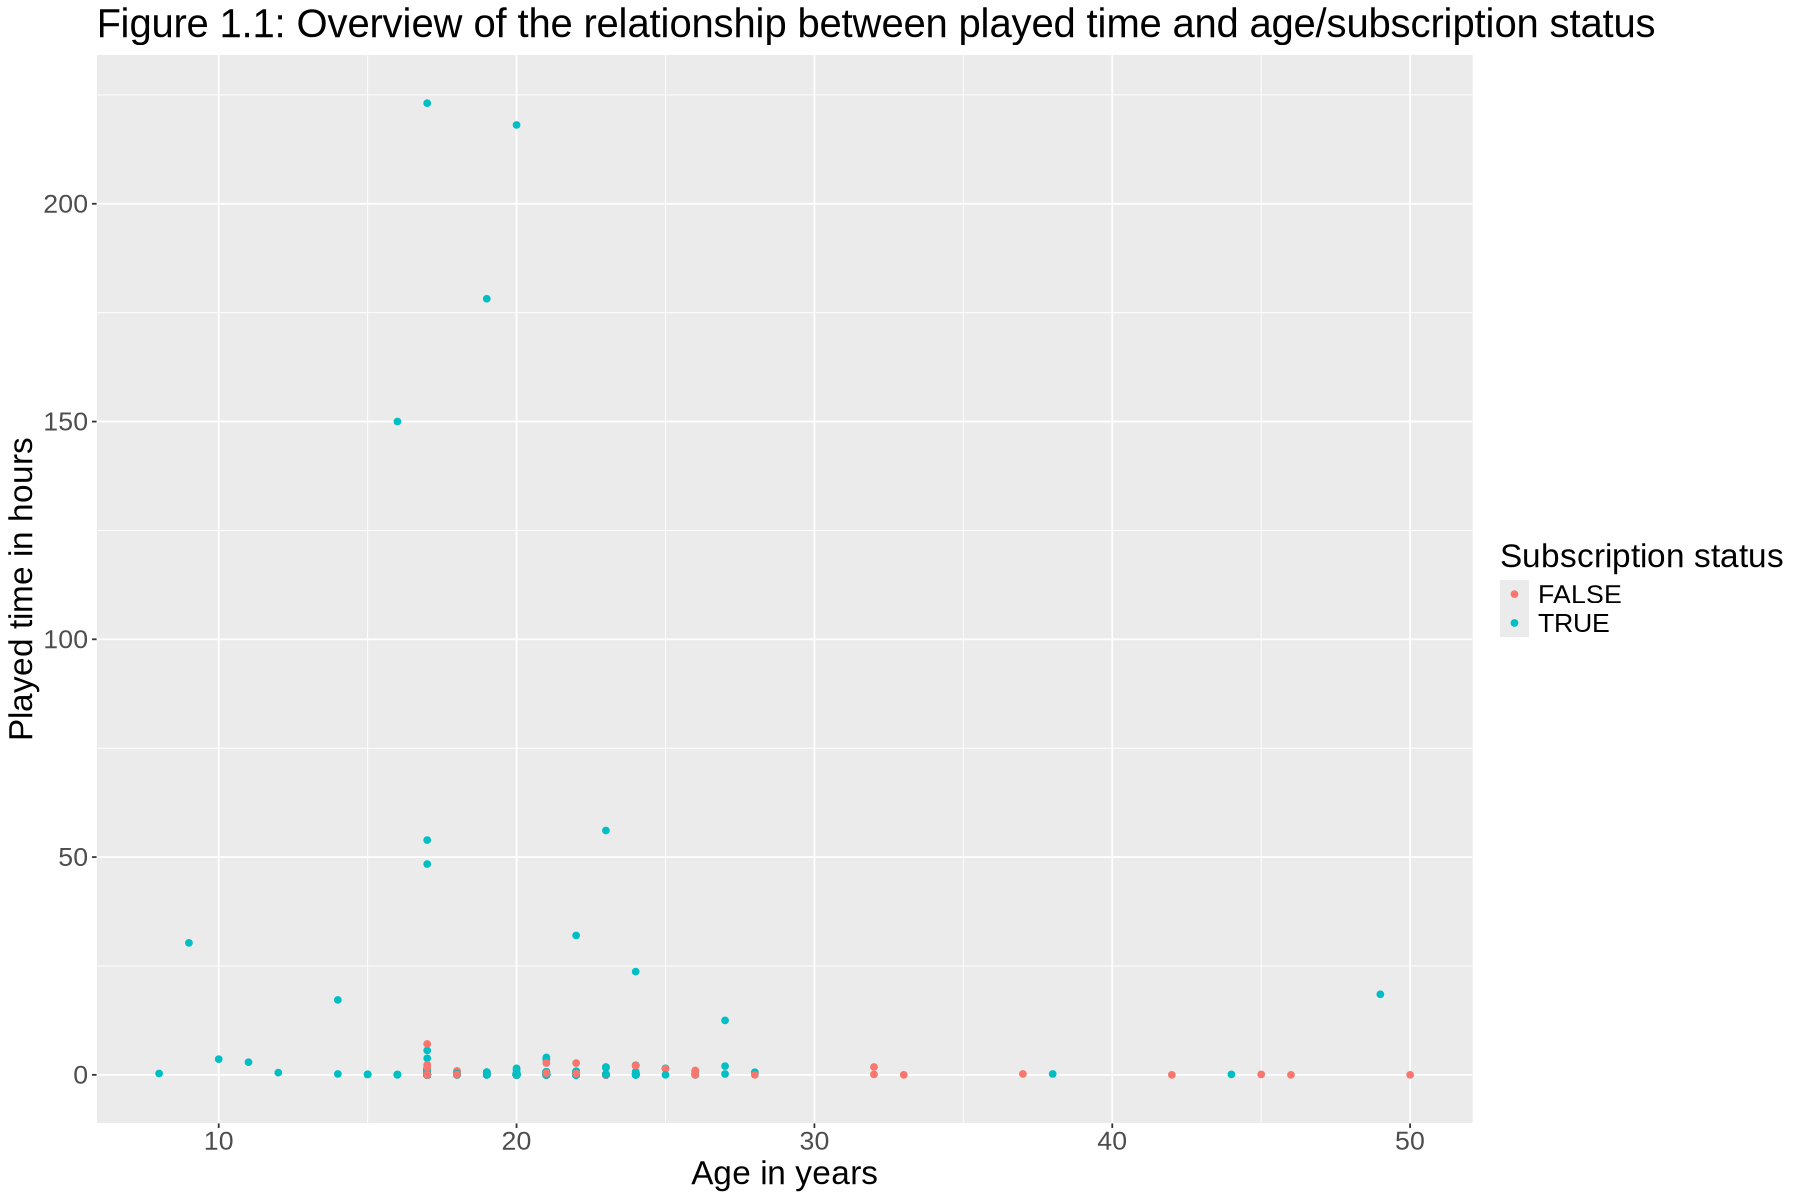

In [17]:
options(repr.plot.width = 15, repr.plot.height = 10)
players_plot <- players |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        labs(title = "Figure 1.1: Overview of the relationship between played time and age/subscription status",x = "Age in years", y = "Played time in hours", colour = "Subscription status") +
        theme(text = element_text(size=20))
players_plot

#### Explanation of Figure 1.1
The above scatter plot displays the relationship between the variables: played hours, age, and subscription status of the players. The data displays that as age increases, there is a decrease in subscriptions and played hours. Based on this, it can be concluded that majority of players with higher played hours are younger, typically under 30 years old. Also, subscribed players have higher played hours compared to non-subscribed players.

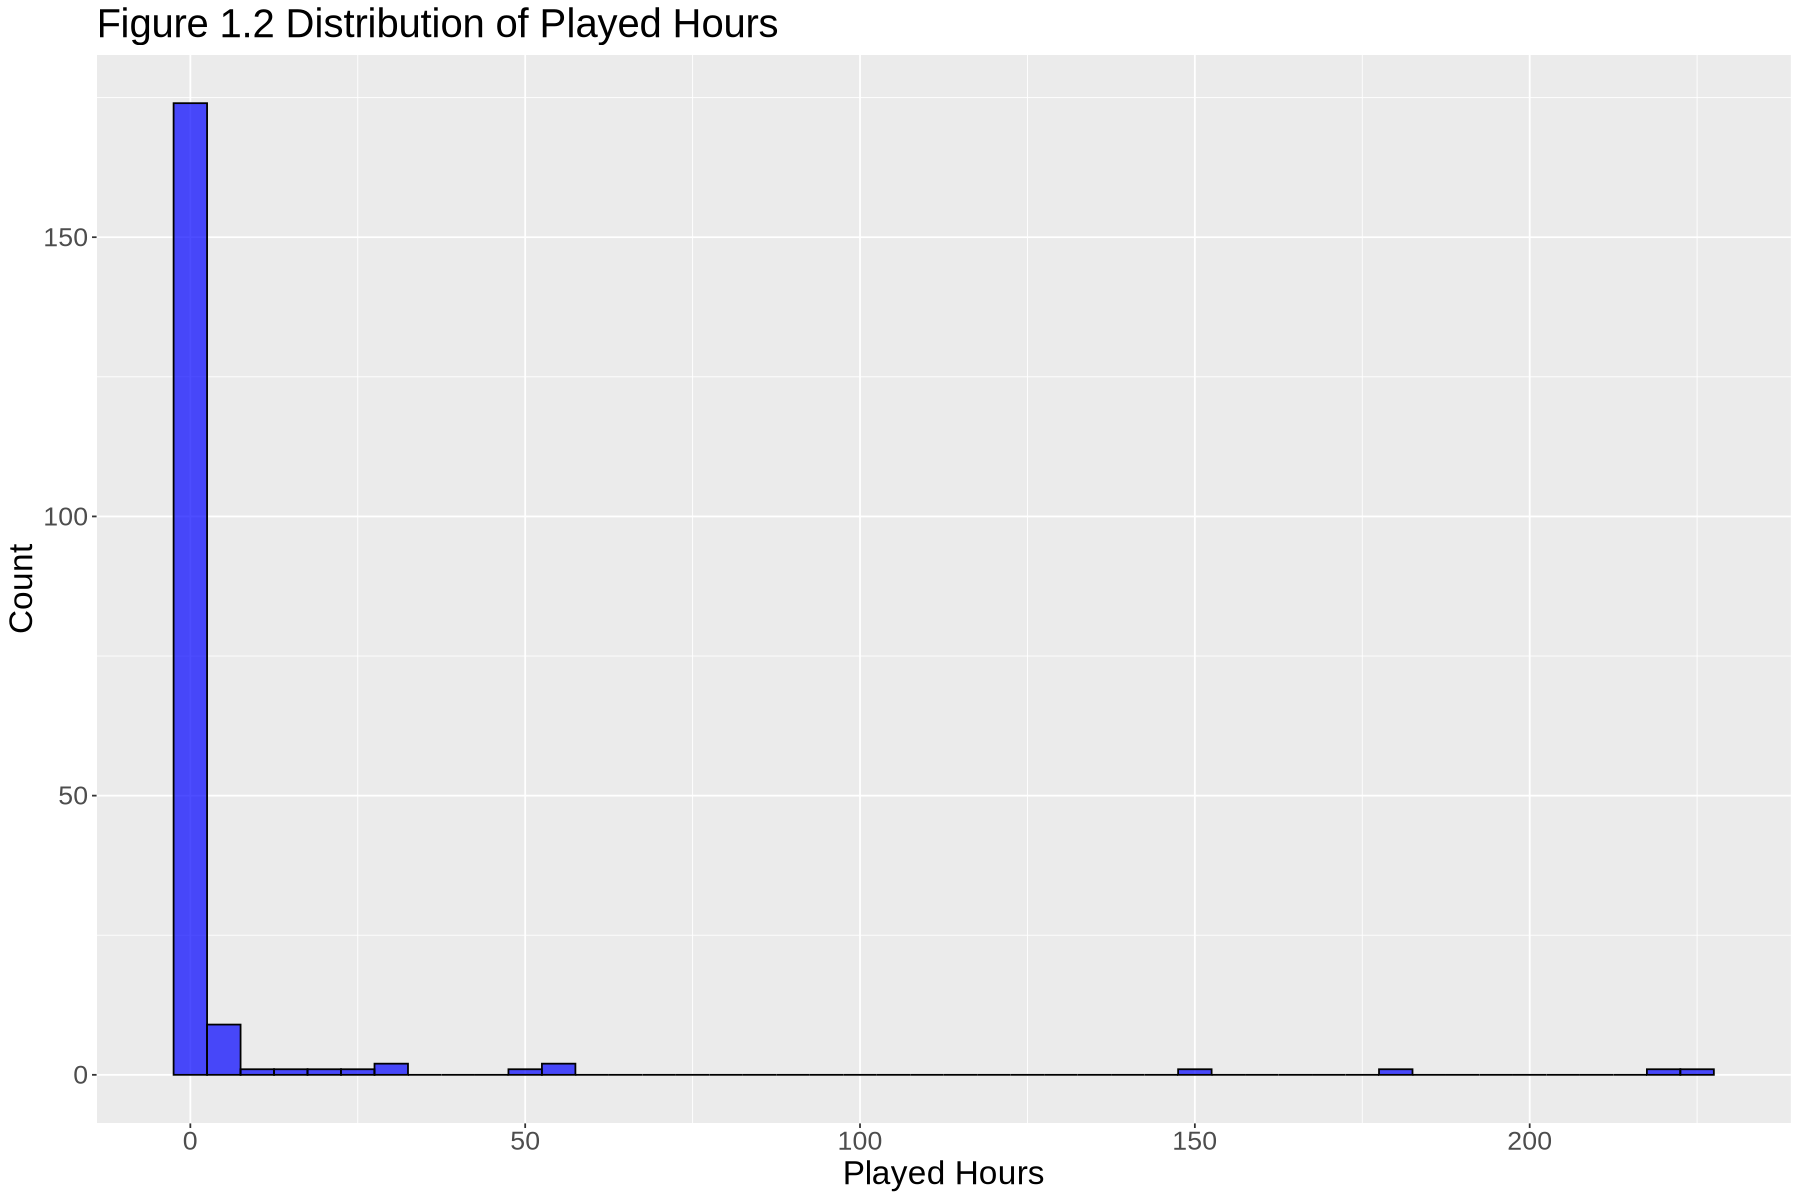

In [18]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Figure 1.2 Distribution of Played Hours", x = "Played Hours", y = "Count") + 
  theme(text=element_text(size=20))

#### Explanation of Figure 1.2
The visualization illustrates the distribution of played hours among players, revealing a highly skewed pattern. The majority of players engage with the game for a very short period, as evident from the tall bar near zero played hours. This suggests that a significant portion of users either try the game briefly before leaving or do not engage consistently over time. Meanwhile, there are only a few players with significantly higher played hours, indicating a small but dedicated group of highly engaged users. The gap between these two groups suggests that there are not many players with moderate engagement levels. Most either play very little or commit substantial time to the game.

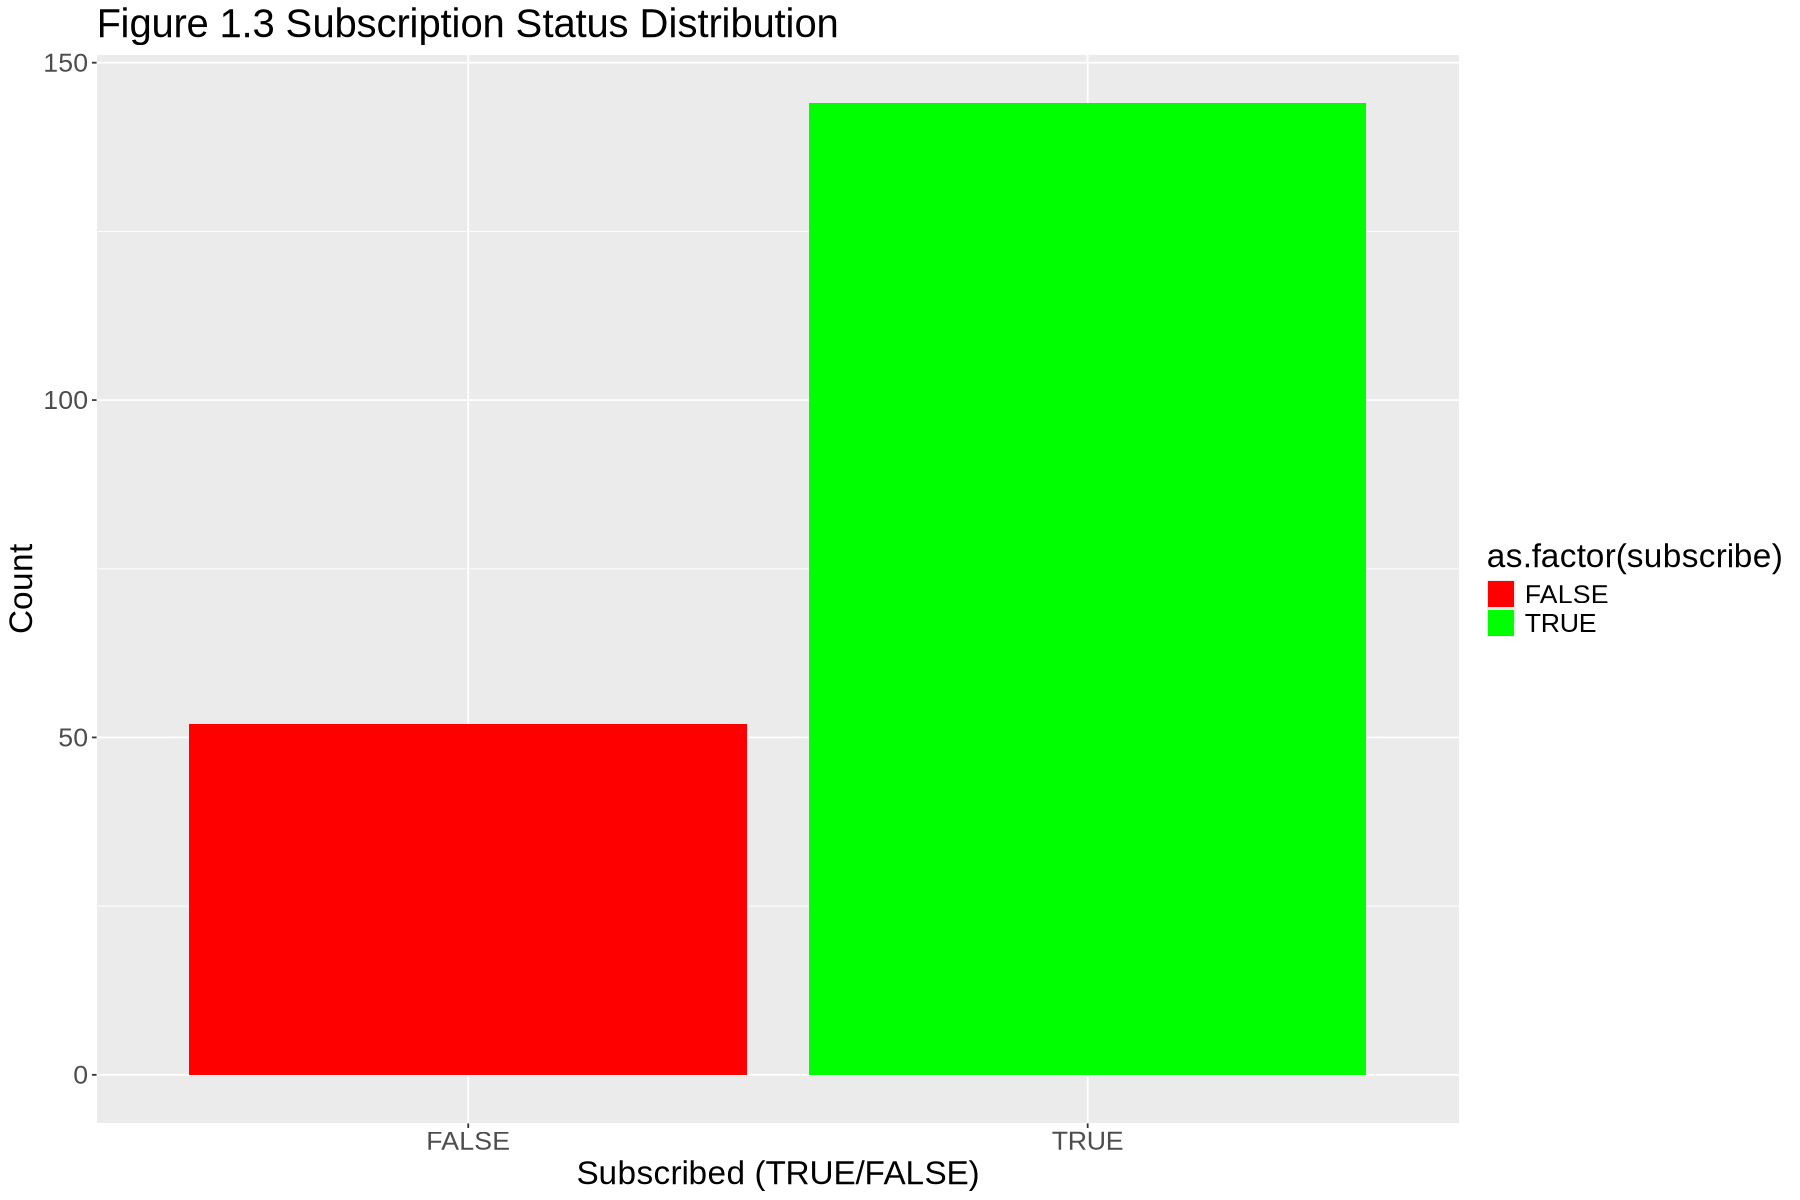

In [20]:
ggplot(players, aes(x = as.factor(subscribe), fill = as.factor(subscribe))) +
  geom_bar() +
  labs(title = "Figure 1.3 Subscription Status Distribution", x = "Subscribed (TRUE/FALSE)", y = "Count") +
  scale_fill_manual(values = c("red", "green")) +
  theme(text = element_text(size=20))

#### Explanation of Figure 1.3:
This bar graph provides a straightforward visualization of the ratio between subscribed and non-subscribed players. We can clearly see that there is almost triple the number of people who are subscribed than those who are not. This could potentially lead to problems with our k-nn classification models as class imbalances. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


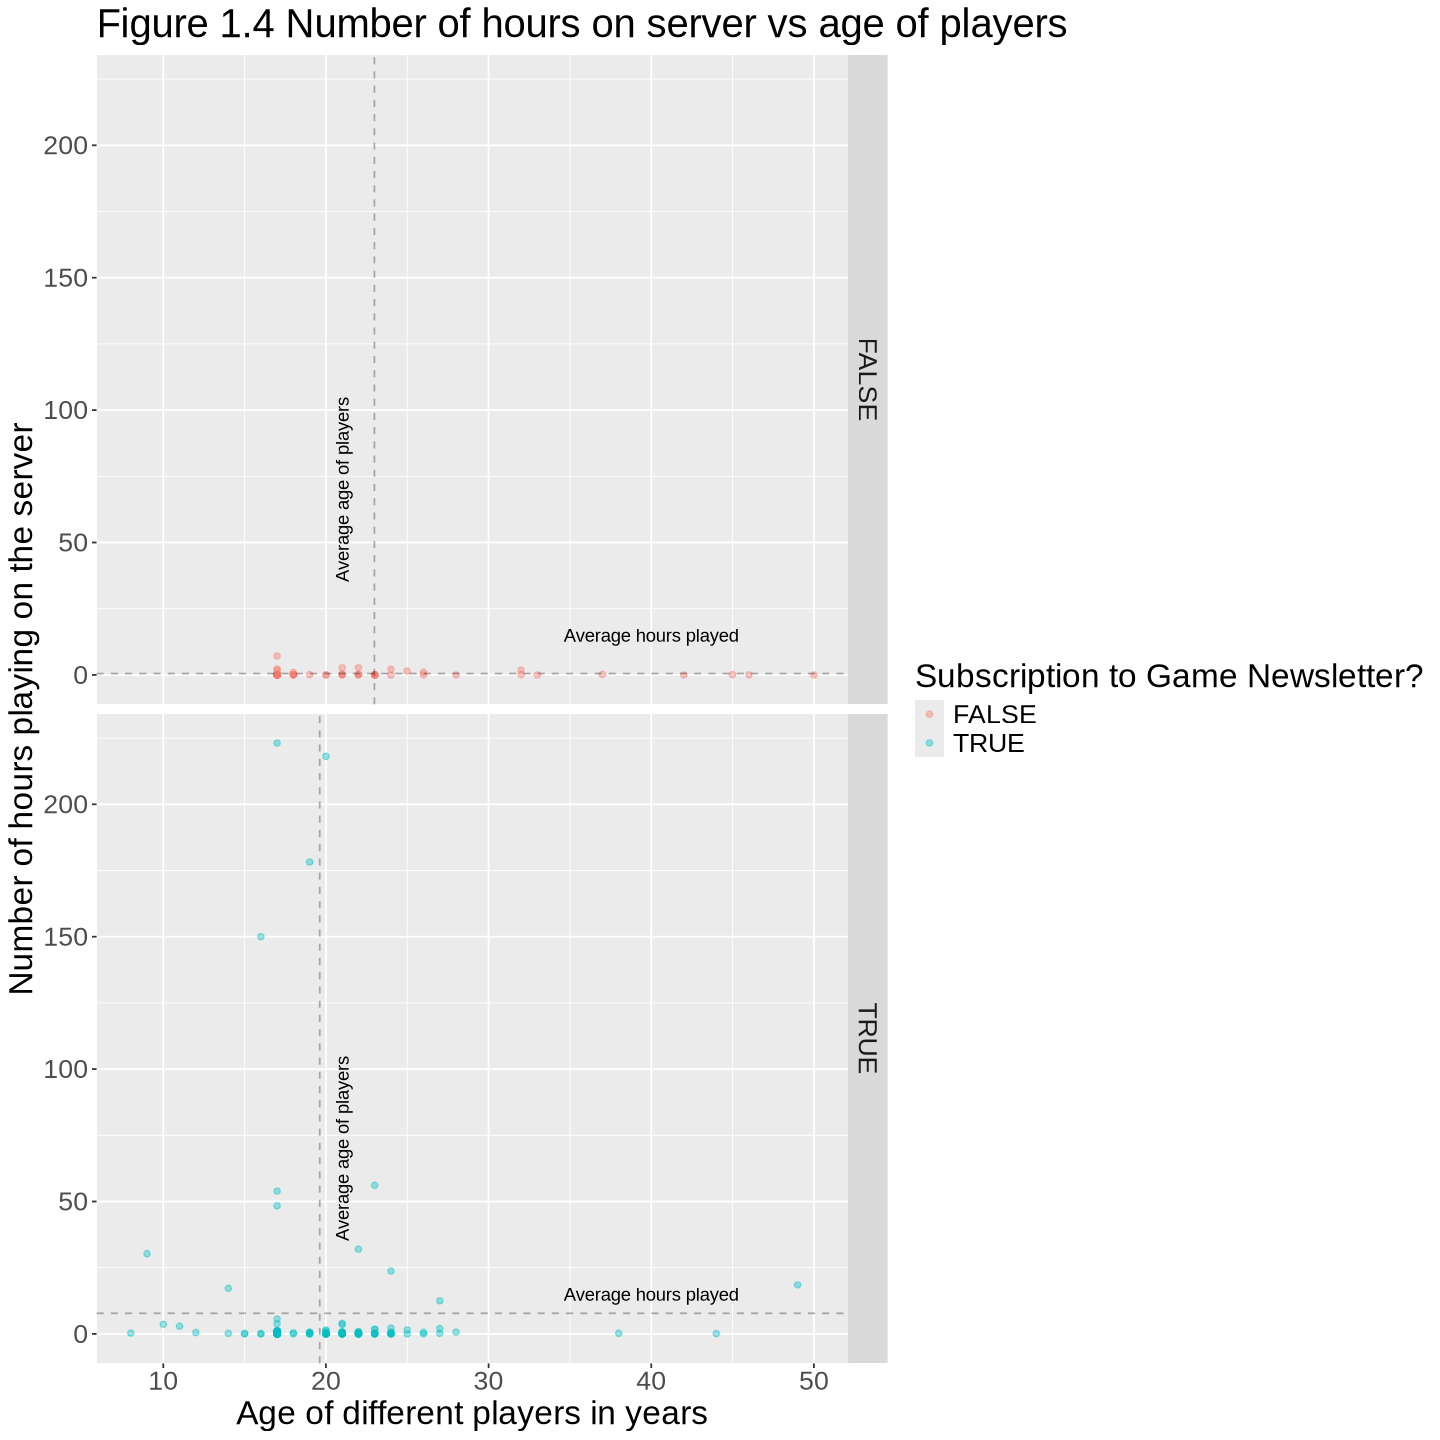

In [21]:
options(repr.plot.width = 12, repr.plot.height = 12)

average_age <- players |>
                select(subscribe, Age) |>
                group_by(subscribe) |>
                summarize(mean=mean(Age, na.rm=TRUE))

average_age_false <- pull(average_age) |> first()
average_age_true <- pull(average_age) |> last()

average_played_hours <- players |>
                        select(subscribe, played_hours) |>
                        group_by(subscribe) |>
                        summarize(mean=mean(played_hours, na.rm=TRUE))

average_played_hours_false <- pull(average_played_hours) |> first()
average_played_hours_true <- pull(average_played_hours) |> last()

played_hours_vs_age_plot <- ggplot(players, aes(x=Age ,y=played_hours,color=as_factor(subscribe))) +
                            geom_point(alpha=0.4) +
                            facet_grid(row=vars(subscribe)) +
                            labs(x="Age of different players in years",
                                y="Number of hours playing on the server",
                                title="Figure 1.4 Number of hours on server vs age of players",
                                color="Subscription to Game Newsletter?") +
                            theme(text=element_text(size=20)) +
                            geom_vline(aes(xintercept=average_age_false), linetype="dashed", data=filter(players, subscribe == FALSE), alpha=0.3) +
                            geom_vline(aes(xintercept=average_age_true), linetype="dashed", data=filter(players, subscribe == TRUE), alpha=0.3) +
                            geom_hline(aes(yintercept=average_played_hours_false), linetype="dashed", data=filter(players, subscribe == FALSE), alpha=0.3) +
                            geom_hline(aes(yintercept=average_played_hours_true), linetype="dashed", data=filter(players, subscribe == TRUE), alpha=0.3) +
                            annotate("text", x=21, y=70, label="Average age of players", angle=90) +
                            annotate("text", x=40, y=15, label="Average hours played")


played_hours_vs_age_plot



#### Explanation of Figure 1.4
This visualization explores the relationship between player age and the number of hours spent on the game server, separated by subscription status True or False. The scatter plot is faceted by subscription status, allowing for a comparison between subscribed and non-subscribed players. The scatter plot shows that most players spend very little time on the server, regardless of age or subscription status. However, subscribed players tend to have higher playtime, with a few extreme outliers exceeding 100 hours. Age does not appear to strongly influence playtime, as both young and older players are spread across similar engagement levels. This suggests that subscription status is a better predictor of playtime than age.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


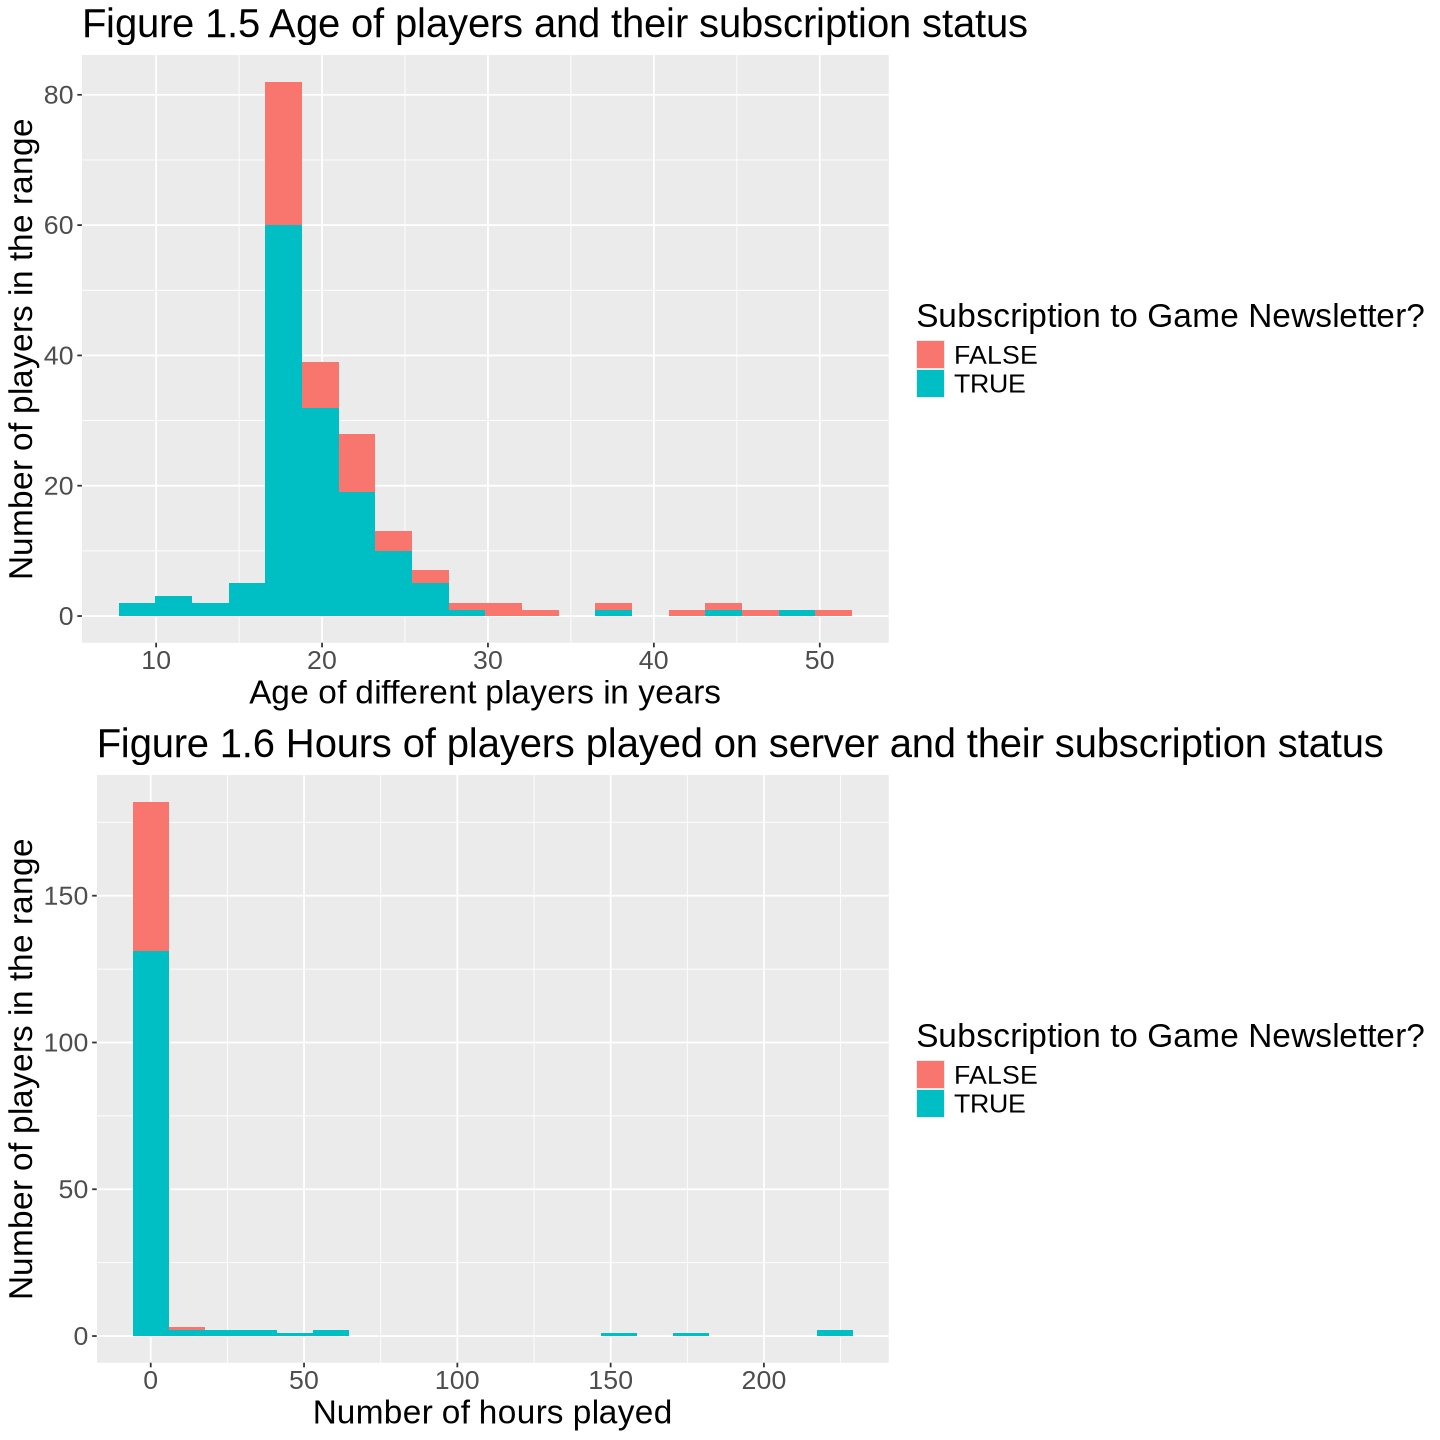

In [22]:
library(cowplot)

age_hist <- ggplot(players, aes(x=Age, fill = as_factor(subscribe))) +
                geom_histogram(bins=20) +
                labs(x="Age of different players in years",
                     y="Number of players in the range",
                    fill="Subscription to Game Newsletter?",
                    title = "Figure 1.5 Age of players and their subscription status") +
                    theme(text=element_text(size=20))

played_hours_hist <- ggplot(players, aes(x=played_hours, fill = as_factor(subscribe))) +
                geom_histogram(bins=20) +
                labs(x="Number of hours played",
                     y="Number of players in the range",
                    fill="Subscription to Game Newsletter?",
                    title = "Figure 1.6 Hours of players played on server and their subscription status") +
                    theme(text=element_text(size=20))

plot_grid(age_hist, played_hours_hist, ncol=1)

#### Explanation of Figure 1.5 and Figure 1.6:
The first histogram (Figure 1.5) shows that most players are between 15 and 25 years old, with a higher proportion of subscribed players (blue) in this range. Few players are older than 30, and subscription rates appear to decline with age.

The second histogram (Figure 1.6) highlights that most players have very low playtime, with a small number of outliers playing significantly more. Subscription status seems to have some impact on engagement, as a larger share of subscribed players have higher playtime compared to non-subscribers. However, overall, engagement remains low for most players, regardless of subscription.

## Data Analysis

### Methods
XXX <br>
XXX <br>
XXX

In [ ]:
## analysis code here for k-nn classifiers


### Results from the predictive analysis

### Visualizations of the predictive analysis

## Final Discussions and concluding thoughts

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?